In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_07a import *

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160); path

PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160')

In [5]:
import PIL,os

In [28]:
Path.ls = lambda x: list(x.iterdir())

In [29]:
path.ls()

[PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/train'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val')]

In [30]:
(path/'val').ls()

[PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val/n03394916'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val/n03417042'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val/n03445777'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val/n02102040'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val/n03425413'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val/n03888257'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val/n03028079'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val/n03000684'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val/n01440764'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/val/n02979186')]

In [37]:
sample_path = (path/'train').ls()[0]; sample_path

PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/train/n03394916')

In [42]:
sample_fname = sample_path.ls()[1]

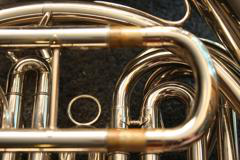

In [43]:
sample_img = PIL.Image.open(sample_fname); sample_img

In [39]:
sample_img.size

(240, 160)

# Filenames

In [47]:
sample_fname.suffix

'.JPEG'

In [117]:
# recursively add suffixes in path to set
def build_suffixes(path, sfx=set()):
    if path.ls()[0].is_file():
        [sfx.add(x.suffix) for x in path.ls()]
    else:
        [build_suffixes(x, sfx) for x in path.ls()]
    return sfx

In [118]:
sfx = build_suffixes(path); sfx

{'.JPEG'}

In [119]:
# recursively add fnames in path to list
def get_filenames(path, fnames=[], sfx=None):
    if path.ls()[0].is_file():
        if sfx: 
            for x in path.ls():
                if x.suffix in sfx:
                    fnames.append(x)
        else: [fnames.append(x) for x in path.ls()]
    else:
        [get_filenames(x, fnames) for x in path.ls()]
    return fnames

In [120]:
fnames = get_filenames(path, [], sfx)
len(fnames)

13394

In [121]:
fnames[:3]

[PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'),
 PosixPath('/Users/adamschiller/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG')]

In [108]:
%timeit -n 10 get_filenames(path)

66.4 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Data

In [122]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

In [164]:
def make_RGB(x): return x.convert('RGB')
def resize_fixed(x, size): return x.resize((size,size), PIL.Image.BILINEAR)

In [186]:
tfms = transforms.Compose([
    make_RGB,
    partial(resize_fixed, size=128),
    transforms.ToTensor(),
    transforms.Normalize(m,s)   # this is added after initial dl creation off one batch
])

In [187]:
train_ds = datasets.ImageFolder((path/'train'), tfms)
val_ds = datasets.ImageFolder((path/'val'), tfms)

In [188]:
trn_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4)

In [189]:
x,y = next(iter(trn_dl))

In [185]:
# normalization stats
m = x.mean((0,2,3))  # mean/channel
s = x.std((0,2,3))   # std/channel
m,s

(tensor([0.4851, 0.4735, 0.4499]), tensor([0.2798, 0.2757, 0.2969]))

In [191]:
# verify normalization
x.mean((0,2,3)), x.std((0,2,3))

(tensor([-0.0441, -0.0300, -0.0626]), tensor([0.9579, 0.9784, 0.9966]))

In [192]:
data = DataBunch(trn_dl, val_dl, len(train_ds.classes))

# Model

In [193]:
cbfs = [partial(AvgStatsCallback,accuracy)] #, CudaCallback]

In [194]:
nfs = [3,16,32,64,64,64,128,256]

In [249]:
def get_cnn(nfs, classes):  
    layers = []
    for i in range(len(nfs)-1):
        stride = 1 if i==0 else 2
        layers.append(conv_layer(nfs[i], nfs[i+1], stride=stride))
    layers+=[nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], classes)]
    return nn.Sequential(*layers)

In [250]:
model = get_cnn(nfs, data.c)
init_cnn(model)

In [252]:
def summary(model, x):
    mods = model.children()
    f = lambda hook,mod,inp,out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: model(x)
        
summary(model, x)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(

In [269]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))

In [270]:
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

In [273]:
run.fit(1, learn)

train: [1.787088129686345, tensor(0.3804)]
valid: [1.4846830214968152, tensor(0.4991)]
